## Create COCO annotation files ##
This notebooks requires the detectron2 library.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd

# Matplotlib for plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import patches

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Detectron2 library
import detectron2
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import dentexmodel as dm
from dentexmodel.fileutils import FileOP
from dentexmodel.imageproc import ImageData, is_image
from dentexmodel.dentexdata import DentexData, val_test_split

print(f'Project module version: {dm.__version__}')
print(f'Detectron2 version:     {detectron2.__version__}')

Project module version: 0.0.post1.dev119+ga07f9cc
Detectron2 version:     0.6


In [2]:
# Data directory (change as needed)
dentex_dir = os.path.join(os.environ['HOME'], 'data', 'dentex')
data_dir = os.path.join(dentex_dir, 'dentex_detection')

# This image directory is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')

# Data frame with data splits 
data_df_file_name = 'dentex_detection_datasplit.parquet'
data_df_file = os.path.join(dentex_dir, data_df_file_name)
data_df = pd.read_parquet(data_df_file)
display(data_df.head(2))

,image_id,file_name,image_number,file_path,dataset
0,327,train_612.png,612,/app/data/dentex/dentex_detection/quadrant_enu...,train
1,543,train_163.png,163,/app/data/dentex/dentex_detection/quadrant_enu...,train


In [3]:
train_set = set(data_df.loc[data_df['dataset'] == 'train', 'file_name'].values)
print(f'We have {len(train_set)} images in the train set.')

val_set = set(data_df.loc[data_df['dataset'] == 'val', 'file_name'].values)
print(f'We have {len(val_set)} images in the validation set.')

test_set = set(data_df.loc[data_df['dataset'] == 'test', 'file_name'].values)
print(f'We have {len(test_set)} images in the test set.')

We have 534 images in the train set.
We have 50 images in the validation set.
We have 50 images in the test set.


### Create the dataset representations ###
https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#register-a-dataset

In [4]:
# Open the json annotation file
# We cannot use this file directly, because we will train a Faster R-CNN model
# This requires a little different annotation representations

annotation_file_name = 'train_quadrant_enumeration.json'
json_file = os.path.join(data_dir, 'quadrant_enumeration', annotation_file_name)

dtx = DentexData(data_dir=data_dir)
annotations = dtx.load_annotations(json_file=json_file)
display(annotations.keys())

# Create one dictionary with all annotation categories
category_dict = dtx.create_category_dict(categories=range(1, 3))
display(category_dict)

dict_keys(['images', 'annotations', 'categories_1', 'categories_2'])

{'categories_1': {0: 1, 1: 2, 2: 3, 3: 4},
 'categories_2': {0: '1',
  1: '2',
  2: '3',
  3: '4',
  4: '5',
  5: '6',
  6: '7',
  7: '8'}}

### Create example annotations for one image ###

In [7]:
# Create the annotations for one image
dataset = 'train'
df = data_df.loc[data_df['dataset'] == 'train']

image_list = sorted(list(df['file_name'].unique()))

idx = 24
file_name = image_list[idx]
file = df.loc[df['file_name'] == file_name, 'file_path'].values[0]

print(file_name)
print(file)

train_127.png
/app/data/dentex/dentex_detection/quadrant_enumeration/xrays/train_127.png


In [5]:
def create_rcnn_anntations(annotations, file):
    file_name = os.path.basename(file)
    # Verify that the image exists
    if is_image(file):
        
        # Find the image annotation
        im_annotation = [dct.copy() for dct in annotations.get('images') if dct.get('file_name') == file_name][0]
        
        # Replace the file_name field in the annotation dictionary with the full path
        im_annotation.update({'file_name': file})
    
        # We also need an 'image_id' field. We can replace the original id.
        image_id = im_annotation.get('id')
        im_annotation.update({'image_id': image_id})
        im_annotation.pop('id')
        
        # Find the list of annotations for one image
        annotation_list = [an_dict for an_dict in annotations.get('annotations') if an_dict.get('image_id') == image_id]
        
        # We pull out just the information that we need into a new list
        record_list = []
        for an_dict in annotation_list:
            im_dict = {'id': an_dict.get('id'),
                       'area': an_dict.get('area'),
                       'iscrowd': an_dict.get('iscrowd'),
                       'bbox': an_dict.get('bbox'),
                       'bbox_mode': BoxMode.XYWH_ABS,
                       'category_id': 0}
            record_list.append(im_dict)
        
        # Add this list of annotations to the image annotation dictionary
        im_annotation.update({'annotations': record_list})

### Register a data set with one image annotation and visualize the bounding boxes ###

In [6]:
# Register the annotations
dataset_name = 'test_dataset'
if dataset_name not in DatasetCatalog:
    DatasetCatalog.register(name=dataset_name, func=lambda d: image_annotation_list.get(d))
    MetadataCatalog.get(dataset_name).set(thing_classes=['tooth'])
dentex_metadata = MetadataCatalog.get(dataset_name)
display(dentex_metadata)

namespace(name='test_dataset', thing_classes=['tooth'])

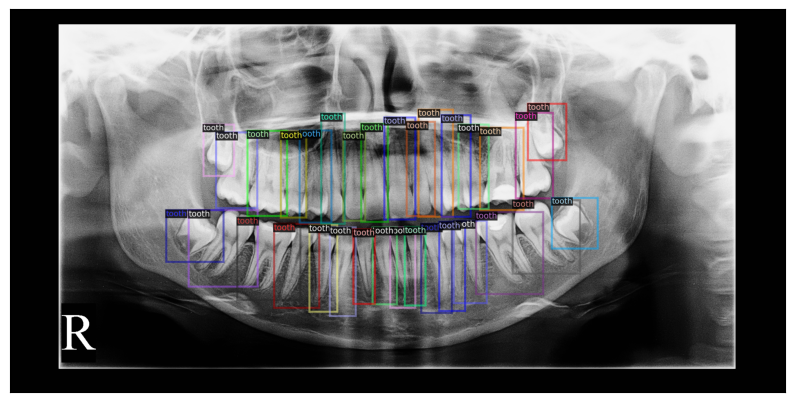

In [19]:
im = ImageData().load_image(file_path)
im_vis = Visualizer(img_rgb=im, metadata=dentex_metadata, scale=1.0)
im_vis_annotated = im_vis.draw_dataset_dict(im_annotation)
im_vis_output_image = im_vis_annotated.get_image()

fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(im_vis_output_image)
ax.set(xticks=[], yticks=[])
plt.show()

### Create image annotations for all images ###